<a href="https://colab.research.google.com/github/christpaul94/MastersThesis_PaulChrist/blob/main/TrappedAtomsSimulation_HarmonicPotential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TrappedAtomsSimulation_HarmonicPotential

Author: Paul Christ

Date: 04.11.2025


In [1]:
!pip install -qq git+https://github.com/christpaul94/MastersThesis_PaulChrist.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.2/552.2 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 23.4 MB/s eta 0:00:00


In [11]:
# Import
from TrappedAtomsSimulation.initialization import initialize_one_temp_gaussian_state, initialize_two_temp_gaussian_state
from TrappedAtomsSimulation.force_calculation import calculate_interaction_strength
from TrappedAtomsSimulation.force_calculation import pair_keops_fp
from TrappedAtomsSimulation.integrators import run_verlet_simulation_HO, solve_harmonic_analytical
from TrappedAtomsSimulation.plot_utils import plot_energy_and_error, plot_thermalization

import torch

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

## Trap

In [4]:
trap_frequencies_Hz = (1000.0, 1050.0, 1200.0)


### One group

In [5]:
# eine gruppe

--- Skalierung basierend auf T = 1.00e-06 K ---
Längenskala L0: 1.56e-06 m, Energieskala E0: 1.38e-29 J, Zeitskala T0: 1.59e-04 s
Initialisiere 10000 Teilchen bei T = 1.00e-06 K
--- Initialisierung abgeschlossen ---



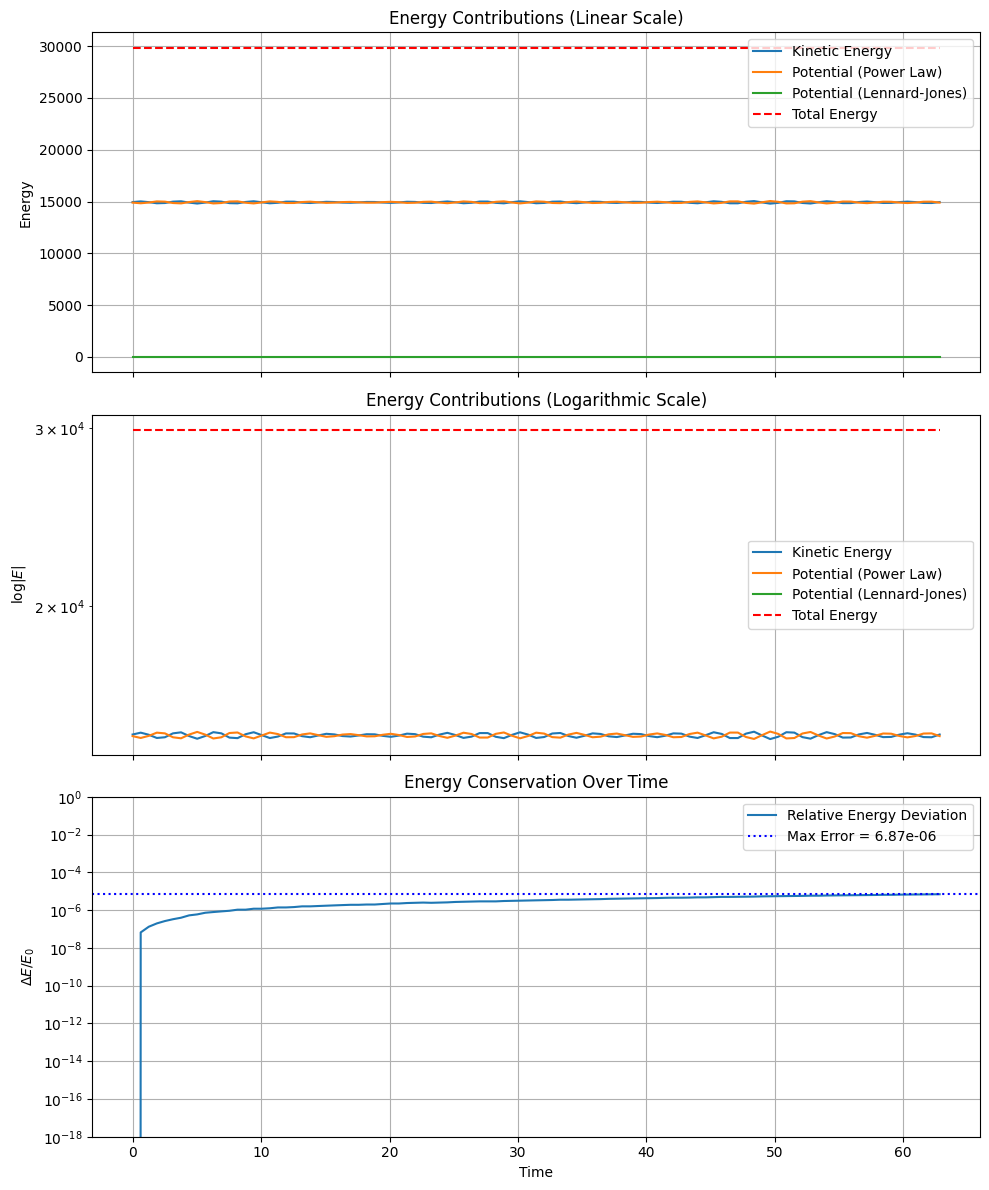

tensor(6.8713e-06, device='cuda:0')

In [6]:
# exakte lösung
simulation_time_s = 0.01
timestep_s = 1e-4
substeps = 10
n_particles = 10000
T = 1e-6

initial_state_params = initialize_one_temp_gaussian_state(
    n_particles=n_particles,
    temp_k=T,
    omega_phys_hz=trap_frequencies_Hz,
    t_end_s=simulation_time_s,
    dt_s=timestep_s,
    r0_phys=None,  # <-- Wichtig: Keine WW
    C_phys=None,   # <-- Wichtig: Keine WW
    precision=dtype,
    device=device
)

integrator_config = {
    "pair_force_func": None, # (wird ignoriert)
    "substeps": 1             # (wird ignoriert)
}

simulation_input_args = {**initial_state_params, **integrator_config}


# ---  Simulation starten ---

results_analytical = solve_harmonic_analytical(**simulation_input_args)
plot_energy_and_error(results_analytical['times'], results_analytical['kinetic_energy'],results_analytical['potential_energy_harmonic'],results_analytical['potential_energy_pair'])


In [30]:
# eine gruppe
simulation_time_s = 0.05
timestep_s = 1e-4
substeps = 100
n_particles = 10000
T = 1e-6

r0_phys,C_phys = calculate_interaction_strength(20)
print((r0_phys,C_phys))


initial_state_params = initialize_one_temp_gaussian_state(
    n_particles=n_particles,
    temp_k=T,
    omega_phys_hz=trap_frequencies_Hz,
    t_end_s=simulation_time_s,
    dt_s=timestep_s,
    r0_phys=r0_phys,
    C_phys=C_phys,
    precision=dtype,
    device=device
)

integrator_config = {
    "pair_force_func": pair_keops_fp,
    "substeps": substeps
}

simulation_input_args = {**initial_state_params, **integrator_config}

# --- Simulation starten ---
simulation_results = run_verlet_simulation_HO(**simulation_input_args)
plot_energy_and_error(simulation_results['times'], simulation_results['kinetic_energy'],simulation_results['potential_energy_harmonic'],simulation_results['potential_energy_pair'])

(1.0475587892e-07, 2.801495869195994e-31)
--- Skalierung basierend auf T = 1.00e-06 K ---
Längenskala L0: 1.56e-06 m, Energieskala E0: 1.38e-29 J, Zeitskala T0: 1.59e-04 s
Initialisiere 10000 Teilchen bei T = 1.00e-06 K
--- Initialisierung abgeschlossen ---

{'t_values': tensor([  0.0000,   0.6283,   1.2566,   1.8850,   2.5133,   3.1416,   3.7699,
          4.3982,   5.0265,   5.6549,   6.2832,   6.9115,   7.5398,   8.1681,
          8.7965,   9.4248,  10.0531,  10.6814,  11.3097,  11.9381,  12.5664,
         13.1947,  13.8230,  14.4513,  15.0796,  15.7080,  16.3363,  16.9646,
         17.5929,  18.2212,  18.8496,  19.4779,  20.1062,  20.7345,  21.3628,
         21.9911,  22.6195,  23.2478,  23.8761,  24.5044,  25.1327,  25.7611,
         26.3894,  27.0177,  27.6460,  28.2743,  28.9027,  29.5310,  30.1593,
         30.7876,  31.4159,  32.0442,  32.6726,  33.3009,  33.9292,  34.5575,
         35.1858,  35.8142,  36.4425,  37.0708,  37.6991,  38.3274,  38.9557,
         39.5841,  40.2124

KeyboardInterrupt: 

### Two groups

In [34]:

n_groups = (21111, 21111) # 2000 kalte, 1000 heiße Teilchen
temp_groups = (1e-6, 2e-6)

initial_state_params = initialize_two_temp_gaussian_state(
    n_particles_groups = n_groups,
    temp_k_groups = temp_groups ,
    omega_phys_hz=trap_frequencies_Hz,
    t_end_s=simulation_time_s,
    dt_s=timestep_s,
    r0_phys=r0_phys,
    C_phys=C_phys*10,
    precision=dtype,
    device=device
)


integrator_config = {
    "pair_force_func": pair_keops_fp,
    "substeps": substeps
}

simulation_input_args = {**initial_state_params, **integrator_config}


# --- Simulation starten ---
simulation_results = run_verlet_simulation_HO(**simulation_input_args)
plot_energy_and_error(simulation_results['times'], simulation_results['kinetic_energy'],simulation_results['potential_energy_harmonic'],simulation_results['potential_energy_pair'])
plot_thermalization(
        results=simulation_results,
        n_groups=n_groups,
        temp_groups=temp_groups,
        T0_s=torch.tensor(initial_state_params['T0_s']) # T0 als Tensor übergeben
    )

--- Skalierung basierend auf Referenztemperatur T_ref = 1.00e-06 K ---
Längenskala L0: 1.56e-06 m, Energieskala E0: 1.38e-29 J, Zeitskala T0: 1.59e-04 s
Initialisiere Gruppe mit 21111 Teilchen bei T = 1.00e-06 K
Initialisiere Gruppe mit 21111 Teilchen bei T = 2.00e-06 K
Skaliere Interaktionsparameter...
--- Zwei-Temperatur-Initialisierung abgeschlossen ---

Integration 10% | Time: 16 min 46 s

KeyboardInterrupt: 